In [ ]:
!pip install datasets transformers evaluate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
import os
import json
from pathlib import Path
import shutil
from datasets import load_dataset
import re
import ast
from PIL import Image
import random
import numpy as np
import cv2

from huggingface_hub import HfFolder, notebook_login

import torch
from transformers import DonutProcessor as DP
from transformers import VisionEncoderDecoderModel as VEDM
from transformers import VisionEncoderDecoderConfig as VEDC
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer



In [ ]:
notebook_login()

In [ ]:
ds = load_dataset("mychen76/invoices-and-receipts_ocr_v1")

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'id', 'parsed_data', 'raw_data'],
        num_rows: 2043
    })
    test: Dataset({
        features: ['image', 'id', 'parsed_data', 'raw_data'],
        num_rows: 125
    })
    valid: Dataset({
        features: ['image', 'id', 'parsed_data', 'raw_data'],
        num_rows: 70
    })
})

In [ ]:
ds['train'][0]['parsed_data']

'{"xml": "", "json": "{\'header\': {\'invoice_no\': \'40378170\', \'invoice_date\': \'10/15/2012\', \'seller\': \'Patel, Thompson and Montgomery 356 Kyle Vista New James, MA 46228\', \'client\': \'Jackson, Odonnell and Jackson 267 John Track Suite 841 Jenniferville, PA 98601\', \'seller_tax_id\': \'958-74-3511\', \'client_tax_id\': \'998-87-7723\', \'iban\': \'GB77WRBQ31965128414006\'}, \'items\': [{\'item_desc\': \\"Leed\'s Wine Companion Bottle Corkscrew Opener Gift Box Set with Foil Cutter\\", \'item_qty\': \'1,00\', \'item_net_price\': \'7,50\', \'item_net_worth\': \'7,50\', \'item_vat\': \'10%\', \'item_gross_worth\': \'8,25\'}], \'summary\': {\'total_net_worth\': \'$7,50\', \'total_vat\': \'$0,75\', \'total_gross_worth\': \'$8,25\'}}", "kie": ""}'

In [ ]:
ds['train'][0]['raw_data']

'{"ocr_words": "[\'Invoice no: 40378170\', \'Date of issue:\', \'10/15/2012\', \'Seller:\', \'Client:\', \'Patel, Thompson and Montgomery\', \'Jackson, Odonnell and Jackson.\', \'356 Kyle Vista\', \'267 John Track Suite 841\', \'New James, MA 46228\', \'Jenniferville, PA 98601\', \'Tax Id: 958-74-3511\', \'Tax Id: 998-87-7723\', \'IBAN: GB77WRBQ31965128414006\', \'ITEMS\', \'UM\', \'No.\', \'Description\', \'Qty\', \'Net price\', \'Net worth\', \'VAT [%]\', \'Gross\', \'worth\', \\" Leed\'s Wine Companion Bottle\\", \'1,00\', \'each\', \'7,50\', \'7,50\', \'10%\', \'8,25\', \'Corkscrew Opener Gift Box Set\', \'with Foil Cutter\', \'SUMMARY\', \'VAT [%]\', \'VAT\', \'Net worth\', \'Gross worth\', \'7,50\', \'10%\', \'0,75\', \'8,25\', \'Total\', \'$7,50\', \'$ 0,75\', \'$8,25\']", "ocr_boxes": "[[[[196.0, 110.0], [801.0, 110.0], [801.0, 161.0], [196.0, 161.0]], (\'Invoice no: 40378170\', 0.9985853433609009)], [[[196.0, 212.0], [517.0, 212.0], [517.0, 259.0], [196.0, 259.0]], (\'Date of 

In [ ]:
new_special_tokens = [] # new tokens which will be added to the tokenizer
task_start_token = "<s>"  # start of task token
eos_token = "</s>" # eos token of tokenizer

def json2token(obj, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
    """
    Convert an ordered JSON object into a token sequence
    """
    if type(obj) == dict:
        if len(obj) == 1 and "text_sequence" in obj:
            return obj["text_sequence"]
        else:
            output = ""
            if sort_json_key:
                keys = sorted(obj.keys(), reverse=True)
            else:
                keys = obj.keys()
            for k in keys:
                if update_special_tokens_for_json_key:
                    new_special_tokens.append(fr"<s_{k}>") if fr"<s_{k}>" not in new_special_tokens else None
                    new_special_tokens.append(fr"</s_{k}>") if fr"</s_{k}>" not in new_special_tokens else None
                output += (
                    fr"<s_{k}>"
                    + json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                    + fr"</s_{k}>"
                )
            return output
    elif type(obj) == list:
        return r"<sep/>".join(
            [json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
        )
    else:
        # excluded special tokens for now
        obj = str(obj)
        if f"<{obj}/>" in new_special_tokens:
            obj = f"<{obj}/>"  # for categorical special tokens
        return obj

In [ ]:
def preprocess_documents_for_donut(sample):
    # create Donut-style input
    samplep1 = ast.literal_eval(re.search('({.+})', sample["parsed_data"]).group(0))
    final_sample = ast.literal_eval(re.search('({.+})', samplep1["json"]).group(0))
    if "header" not in samplep1.keys():
      d_doc = task_start_token + json2token(final_sample) + eos_token
    else:
      d_doc = task_start_token + json2token(final_sample['header']) + json2token(final_sample['items'][0]) + json2token(final_sample['summary']) + eos_token
    # convert all images to RGB
    image = sample["image"].convert('RGB')
    return {"image": image, "text": d_doc}

In [ ]:
proc_dataset_valid = ds['valid'].map(preprocess_documents_for_donut)

Map:   0%|          | 0/70 [00:00<?, ? examples/s]

In [ ]:
proc_dataset_train = ds['train'].map(preprocess_documents_for_donut)


Map:   0%|          | 0/2043 [00:00<?, ? examples/s]

In [ ]:
proc_dataset_train = proc_dataset_train.remove_columns(["parsed_data", "id", "raw_data"])
proc_dataset_valid = proc_dataset_valid.remove_columns(["parsed_data", "id", "raw_data"])
print(proc_dataset_train[0])
print(proc_dataset_valid[0])

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2481x3508 at 0x7991DD904310>, 'text': "<s><s_summary><s_total_vat>$0,75</s_total_vat><s_total_net_worth>$7,50</s_total_net_worth><s_total_gross_worth>$8,25</s_total_gross_worth></s_summary><s_items><s_item_vat>10%</s_item_vat><s_item_qty>1,00</s_item_qty><s_item_net_worth>7,50</s_item_net_worth><s_item_net_price>7,50</s_item_net_price><s_item_gross_worth>8,25</s_item_gross_worth><s_item_desc>Leed's Wine Companion Bottle Corkscrew Opener Gift Box Set with Foil Cutter</s_item_desc></s_items><s_header><s_seller_tax_id>958-74-3511</s_seller_tax_id><s_seller>Patel, Thompson and Montgomery 356 Kyle Vista New James, MA 46228</s_seller><s_invoice_no>40378170</s_invoice_no><s_invoice_date>10/15/2012</s_invoice_date><s_iban>GB77WRBQ31965128414006</s_iban><s_client_tax_id>998-87-7723</s_client_tax_id><s_client>Jackson, Odonnell and Jackson 267 John Track Suite 841 Jenniferville, PA 98601</s_client></s_header></s>"}
{'image': <PIL.PngI

In [ ]:
processor = DP.from_pretrained("naver-clova-ix/donut-base")

processor.tokenizer.add_special_tokens({"additional_special_tokens": new_special_tokens + [task_start_token] + [eos_token]})

processor.image_processor.size = [224, 224]
processor.image_processor.do_align_long_axis = False

preprocessor_config.json:   0%|          | 0.00/362 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.01M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/71.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/355 [00:00<?, ?B/s]

In [ ]:
def transform_and_tokenize(sample, processor = processor, split = "train", max_length = 8, ignore_id = -100):
  # Create image tensors
  pixel_values = processor(sample["image"], random_padding = split == "train", return_tensors = "pt").pixel_values.squeeze()

  # Tokenize document
  input_ids = processor.tokenizer(sample["text"], add_special_tokens = False, padding = "max_length", max_length = max_length, truncation = True, return_tensors = "pt")["input_ids"].squeeze(0)

  labels = input_ids.clone()
  labels[input_ids == processor.tokenizer.pad_token_id] = ignore_id

  return {"pixel_values": pixel_values, "target_sequence": sample["text"], "labels": labels}



In [ ]:
train_dataset = proc_dataset_train.map(transform_and_tokenize, remove_columns = ["image", "text"])
valid_dataset = proc_dataset_valid.map(transform_and_tokenize, remove_columns = ["image", "text"])

Map:   0%|          | 0/2043 [00:00<?, ? examples/s]

Map:   0%|          | 0/70 [00:00<?, ? examples/s]

In [ ]:
valid_dataset

In [ ]:
train_dataset

In [ ]:
model = VEDM.from_pretrained("naver-clova-ix/donut-base")

# Resizing the embedding layer to match vocab size
new_emb = model.decoder.resize_token_embeddings(len(processor.tokenizer))

# Adjusting image size and output sequence lengths
model.config.encoder.image_size = processor.image_processor.size[::-1]
model.config.decoder.max_length = len(max(train_dataset["labels"], key = len))

# Add task token for decoder at start
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids([task_start_token])[0]


In [ ]:
hf_repo_id = "subhuatharva/donut_base_reciptOCRfree"

# arguments for training
training_args = Seq2SeqTrainingArguments(
    output_dir=hf_repo_id,
    num_train_epochs=1,
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    weight_decay=0.01,
    fp16 = True,
    logging_steps = 100,
    save_total_limit = 2,
    eval_strategy = "epoch",
    predict_with_generate = True,

    # pushing to hub
    report_to=["tensorboard"],
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=hf_repo_id,
    hub_token = HfFolder.get_token(),
)

# Creating trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
)


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss


In [ ]:
processor.save_pretrained(hf_repo_id)
trainer.create_model_card()
trainer.push_to_hub()

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1720551605.1996c7576597.15596.1:   0%|          | 0.00/12.1k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/subhuatharva/donut_base_reciptOCRfree/commit/aeaeab0a7669c2b86981884601eba35a1e18c90c', commit_message='End of training', commit_description='', oid='aeaeab0a7669c2b86981884601eba35a1e18c90c', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# Loading random document images from the test set
proc_dataset_test = ds['test'].map(preprocess_documents_for_donut)
proc_dataset_test = proc_dataset_test.remove_columns(["parsed_data", "id", "raw_data"])
test_dataset = proc_dataset_test.map(transform_and_tokenize, remove_columns = ["image", "text"])

Map:   0%|          | 0/125 [00:00<?, ? examples/s]

Map:   0%|          | 0/125 [00:00<?, ? examples/s]

In [ ]:
test_sample = test_dataset[random.randint(0,len(test_dataset))]
test_sample["target_sequence"]

"<s><s_total>26.77</s_total><s_tips></s_tips><s_time>01:02PM</s_time><s_telephone>206-441-9785</s_telephone><s_tax>2.32</s_tax><s_subtotal>24.45</s_subtotal><s_store_name>Max'sCafe</s_store_name><s_store_addr>2200FifthAve Seattle,WA98121</s_store_addr><s_line_items><s_item_value>12.50</s_item_value><s_item_quantity>1</s_item_quantity><s_item_name>BenSPECIAL</s_item_name><s_item_key></s_item_key><sep/><s_item_value>10.00</s_item_value><s_item_quantity>1</s_item_quantity><s_item_name>Caprese</s_item_name><s_item_key></s_item_key><sep/><s_item_value>1.00</s_item_value><s_item_quantity>1</s_item_quantity><s_item_name>AddChicken</s_item_name><s_item_key></s_item_key><sep/><s_item_value>7.00</s_item_value><s_item_quantity>1</s_item_quantity><s_item_name>PineappleBellin</s_item_name><s_item_key></s_item_key></s_line_items><s_ignore></s_ignore><s_date>Jul19'14</s_date></s>"

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Reference :  {'total': '12.97', 'tips': '', 'time': '', 'telephone': '702-399-8282', 'tax': '0.98', 'subtotal': '11.98', 'store_name': 'SAMDAEKOREANBBQ', 'store_addr': 'LASVEGASNV89103 6112WFLAMINGORD', 'line_items': {'item_value': '11.99', 'item_quantity': '1', 'item_name': 'OPENPRICE', 'item_key': ''}, 'ignore': '', 'date': ''}
Prediction :  ['<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><

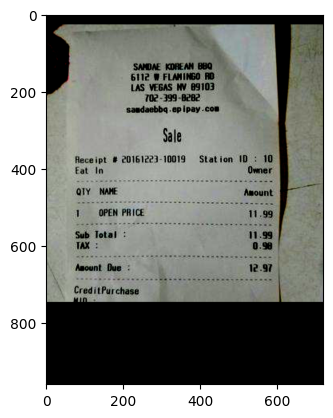

In [ ]:
import transformers
transformers.logging.disable_default_handler()
hf_repo_id = "subhuatharva/donut_base_reciptOCRfree"
# Loading fine tuned model
processor = DP.from_pretrained(hf_repo_id)
model = VEDM.from_pretrained(hf_repo_id)

# Configuring our device
device = "cpu" # "cuda" if GPU is available
model.to(device)



test_sample = test_dataset[random.randint(0,len(test_dataset)-1)]


def run_prediction(sample, model = model, processor = processor):
  # Inputs
  pixel_values = torch.tensor(sample["pixel_values"]).unsqueeze(0)

  task_prompt = "<s>"
  decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens = False, return_tensors = "pt").input_ids

  # Inferencing
  outputs = model.generate(pixel_values.to(device),
                           decoder_input_ids = decoder_input_ids.to(device),
                           max_length = model.decoder.config.max_position_embeddings,
                           early_stopping = False,
                           pad_token_id = processor.tokenizer.pad_token_id,
                           eos_token_id = processor.tokenizer.eos_token_id,
                           use_cache = True,
                           num_beams = 2,
                           bad_words_ids = [[processor.tokenizer.unk_token_id]],
                           return_dict_in_generate = True)
  # Processing outputs
  predictions = processor.batch_decode(outputs.sequences)
  #predictions = predictions.token2json(predictions)

  # Loading inference targets
  target = processor.token2json(sample["target_sequence"])
  #target = target.token2json(target)

  return predictions, target, outputs

prediction, target, outputs = run_prediction(test_sample)
print("Reference : ", target)
print("Prediction : ", prediction)


pixel_values_array = np.array(test_sample["pixel_values"])
image = pixel_values_array.transpose(1,2,0)
plt.imshow(image)

In [ ]:
outputs

NameError: name 'outputs' is not defined